In [42]:
import numpy as np
import scipy.signal as scipysig
from typing import Tuple
import scipy.stats as scipystats
import matplotlib.pyplot as plt

np.set_printoptions(formatter={'float_kind':"{:.2f}".format})
A = np.array([[0.7, 0], [0.1, 0.3]])
B = np.array([[0.5], [0.1]])

dim_x = 2
dim_u = 1
def correlate(x: np.ndarray, num_lags: int):
    n, T = x.shape
    R = np.zeros((num_lags,n,n))

    for m in range(num_lags):
        for i in range(m, T):
            R[m] += x[:,i:i+1] @ x[:, i-m:i-m+1].T
    return R


def collect_data(steps: int, std_u: float, std_w: float) -> Tuple[np.ndarray, np.ndarray]:
    U = np.zeros((dim_u, steps))
    X = np.zeros((dim_x, steps + 1))
    W = np.zeros((dim_x, steps))
    X[:, 0] = np.random.normal(size=(dim_x))

    for i in range(steps):
        U[:, i] = std_u * np.random.normal(size=(dim_u))
        W[:, i] = std_w * np.random.normal(size=(dim_x))
        X[:, i+1] = A @ X[:, i] +  np.squeeze(B * U[:, i]) + W[:, i]#(low=-0.1, high=0.1)#(size=(dim_x))

    return X, U, W

std_w = 0#1e-1
std_u = 1
sample_size = 1000


X, U, W = collect_data(sample_size, std_u, std_w)

attack_amplitude = 0.1
attack_X = np.random.uniform(low=0.5-attack_amplitude, high=attack_amplitude, size=(dim_x, sample_size+1))
attack_U = np.random.uniform(low=0.5-attack_amplitude, high=attack_amplitude, size=(dim_u, sample_size))


Xtilde = X + attack_X
Utilde = U + attack_U

D = np.vstack([X[:,:-1], U])
Dtilde = np.vstack([Xtilde[:,:-1], Utilde])

AB = X[:,1:] @ np.linalg.pinv(D)
ABtilde = Xtilde[:,1:] @ np.linalg.pinv(Dtilde)
F = np.eye(sample_size) - np.linalg.pinv(Dtilde) @ Dtilde
DT, UT = np.linalg.eigh(F)
DT = np.abs(DT)

residuals = Xtilde[:, 1:] -  ABtilde @ Dtilde

DeltaW = attack_X[:,1:] - np.hstack((A, B)) @ np.vstack((attack_X[:, :-1], attack_U))
print(np.linalg.norm(residuals, 'fro') ** 2)
print(np.linalg.norm(DeltaW @ F, 'fro') ** 2)
print(np.trace(DeltaW @ F @ DeltaW.T))
print(np.trace(DeltaW @ UT @ np.diag(DT) @ UT.T @ DeltaW.T))
R = correlate(residuals, 10)
print(sample_size*np.trace(R[0]))

27.34651243475848
27.34651243475848
27.346512434758484
27.346512434758488
27346.51243475848


In [2]:
print(np.linalg.norm(DeltaW, 'fro') ** 2)
print(np.linalg.norm(DeltaW @ UT, 'fro') ** 2)
print(np.linalg.norm(DeltaW @ UT @ np.power(np.diag(DT), 0.5), 'fro') ** 2)
print(np.sum(np.linalg.norm(DeltaW, 2, axis=0) ** 2))

39.92306978212747
39.92306978212746
27.722797280925036
39.92306978212747


In [15]:
print(np.linalg.norm(DeltaW[:, :] @ (UT @ np.diag(DT)), 'fro') ** 2)
print(np.linalg.norm(DeltaW[:, :] @ (UT @ np.diag(DT))[:,3:], 'fro') ** 2)
print(np.linalg.norm(DeltaW[:, :] @ UT[:,3:], 'fro') ** 2)

27.72279728092502
27.72279728092502
27.72279728092503


In [14]:
print(np.linalg.norm(DeltaW[:, :] @ UT[:,3:], 'fro') ** 2)

27.72279728092503


In [45]:
idx = 200
print(np.linalg.norm(UT[:,3:], 'fro'))
print(np.linalg.norm(DeltaW[:, :] @UT[:,3+idx][:, None], 'fro') ** 2)
print(np.linalg.norm(DeltaW, 'fro') ** 2 )

31.575306807693888
0.07866282524366541
39.92306978212747


In [44]:
print(np.sum(np.linalg.norm(DeltaW, 2, axis=0) ** 2))

39.92306978212747


In [57]:
#attack_X[:,1:] - np.hstack((A, B)) @ np.vstack((attack_X[:, :-1], attack_U))
(np.linalg.norm(attack_X[:,1:]- A @ attack_X[:,:-1], 2, axis=0) ** 2).sum()

48.5688068415231

(array([0.25, 1.15, 3.56, 7.02, 11.88, 13.08, 8.32, 3.61, 1.15, 0.10]),
 array([-0.10, -0.08, -0.06, -0.04, -0.02, -0.00, 0.02, 0.04, 0.06, 0.08,
        0.10]),
 <BarContainer object of 10 artists>)

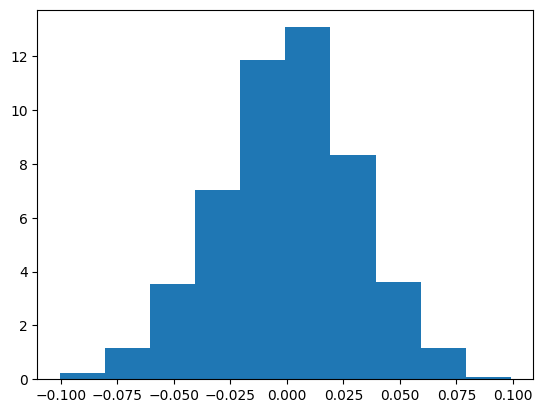

In [53]:
from scipy.stats import norm

val = []
for i in range(1000):
    x = np.random.normal(size=(1, 1000))
    R = correlate(x,2)
    T= 1000

    val.append((R[1]/np.sqrt(T)).item())


plt.hist(val, density=True)

In [24]:
np.array(val).shape

(100, 1, 1)